# **Modelling and Evaluation V5 SNAPSHOT**

## Objectives

* Answer business requirement 1:
    * The client aims to visually differentiate lesions. The model should be capable of reaching an accuracy of at least 70%.
<br><br>

* Answer business requirement 2:
    - The model should provide a confidence level for each prediction.
<br><br>

* Answer business requirement 3:
    - If a skin lesion is predicted as malignant with high confidence, the system should recommend immediate medical consultation.
<br><br>

* Answer business requirement 5:
    - The AI model's insights should assist healthcare professionals in making informed decisions about the treatment process.
<br><br>

* Answer business requirement 6:
    - The model's performance will be evaluated using balanced performance metrics such as F1 Score.
<br><br>
## Inputs

* inputs/skin_cancer_dataset/sorted_images/train
* inputs/skin_cancer_dataset/sorted_images/test
* inputs/skin_cancer_dataset/sorted_images/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments

* V6 - Xception architecture as its base with smaller image size and downsampling
<br><br>

* This model can be used for image classification tasks where you have multiple classes. It leverages the power of a pre-trained Xception model and fine-tunes it with additional custom layers to suit the specific classification problem.

---

---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib
import tensorflow as tf
import shutil

2023-06-22 02:15:55.868023: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

# Change working directory

In [2]:
current_dir = os.getcwd()
current_dir

'/Users/danielhamilton/CI/project5/AI-DermDiagnosis/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/Users/danielhamilton/CI/project5/AI-DermDiagnosis'

---

## Set input directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/skin_cancer_dataset/sorted_images'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'modelling_evaluation_v6'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


In [7]:
new_train_path = file_path + '/new_train'

# Check if the directory exists, if not, create it
if not os.path.exists(new_train_path):
    os.makedirs(new_train_path)

## Set label names

In [8]:
# Set the labels
train_labels = os.listdir(train_path)
print('Label for train set the images are', train_labels, 'there are', len(train_labels) )
test_labels = os.listdir(test_path)
print('Label for test set the images are', test_labels, 'there are', len(test_labels) )
val_labels = os.listdir(val_path)
print('Label for val set the images are', val_labels, 'there are', len(val_labels) )

Label for train set the images are ['akiec', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel'] there are 7
Label for test set the images are ['akiec', '.DS_Store', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel'] there are 8
Label for val set the images are ['akiec', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel'] there are 7


## Set image shape

In [9]:
image_shape = (75, 75, 3)
image_shape

(75, 75, 3)

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/modelling_evaluation_v6/image_shape.pkl']

In [11]:
## Import saved image shape embedding
import joblib
image_shape = joblib.load(filename=f"{file_path}/image_shape.pkl")
image_shape

(75, 75, 3)

---

## Build training, validation and test set

In [12]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def balance_dataset(original_directory, new_directory, target_size=(75, 75), batch_size=32, target_count=800):
    datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Rotation within a range of +/- 10 degrees
    zoom_range=0.1,  # Zoom in or out by 10%
    horizontal_flip=True,  # Horizontal flip
    vertical_flip=True,   # Vertical flip
    brightness_range=(0.9, 1.1),  # Slightly adjust brightness
    width_shift_range=0.1,  # Horizontal shift within a range of +/- 10% of the width
    height_shift_range=0.1  # Vertical shift within a range of +/- 10% of the height
)
    
    # Loading the data
    generator = datagen.flow_from_directory(
        directory=original_directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )
    
    # Count the number of images per class
    _, y = next(generator)
    class_counts = np.sum(y, axis=0)
    
    # Create a new directory to store the balanced dataset
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    for class_name in generator.class_indices.keys():
        os.makedirs(os.path.join(new_directory, class_name), exist_ok=True)
    
    # For each class, either select or augment images
    for i, class_name in enumerate(generator.class_indices.keys()):
        src_class_dir = os.path.join(original_directory, class_name)
        dest_class_dir = os.path.join(new_directory, class_name)
        
        # List of all file names in this class directory
        file_names = os.listdir(src_class_dir)
        
        # If more than target_count, randomly select target_count images
        if class_counts[i] > target_count:
            file_names = np.random.choice(file_names, target_count, replace=False)
            # Copy the selected files to the new directory
            for file_name in file_names:
                shutil.copy(os.path.join(src_class_dir, file_name), dest_class_dir)
        # If fewer than target_count, select files to duplicate until reaching target_count
        elif class_counts[i] < target_count:
            num_to_add = target_count - class_counts[i]
            file_names_to_duplicate = np.random.choice(file_names, int(num_to_add))
            # Duplicate the selected files
            for j, file_name in enumerate(file_names_to_duplicate):
                shutil.copy(os.path.join(src_class_dir, file_name), os.path.join(dest_class_dir, f"copy_{j}_{file_name}"))
        # If equal to target_count, just copy all files
        else:
            for file_name in file_names:
                shutil.copy(os.path.join(src_class_dir, file_name), dest_class_dir)

In [13]:
# Define image dimensions, batch size and seed
img_height = 75
img_width = 75
batch_size = 32
my_seed = 123

# Set random seeds
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

# Define original and new paths for the training dataset
original_train_path = train_path

# Balance the dataset by creating a new directory with balanced classes
balance_dataset(original_train_path, new_train_path, target_count=1000)

# Load the balanced training dataset
df_train = tf.keras.utils.image_dataset_from_directory(
    new_train_path,  # Use the new path for balanced dataset
    seed=my_seed,
    color_mode="rgb",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)

# Load the validation dataset
df_val = tf.keras.utils.image_dataset_from_directory(
    val_path,
    seed=my_seed,
    color_mode="rgb",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)

# Load the test dataset
df_test = tf.keras.utils.image_dataset_from_directory(
    test_path,
    seed=my_seed,
    color_mode="rgb",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="int"
)

# Extract class names
class_names = df_train.class_names

# Define normalization layer
normalization_layer = tf.keras.layers.Rescaling(scale=1./255, offset=0)

# Normalize the datasets
df_train = df_train.map(lambda x, y: (normalization_layer(x), y))
df_val = df_val.map(lambda x, y: (normalization_layer(x), y))
df_test = df_test.map(lambda x, y: (normalization_layer(x), y))


Found 7007 images belonging to 7 classes.
Found 6968 files belonging to 7 classes.
Found 998 files belonging to 7 classes.
Found 2010 files belonging to 7 classes.


In [14]:
# check if data was loaded correctly
y = np.concatenate([y for x, y in df_train], axis=0)
print(len(y))
print(len(df_train))
ranges = [0] * 7
for class_id in np.unique(y, axis=0):
    for cl in y:
        if (class_id == cl):
            ranges[class_id] += 1
    
print(ranges)
print(sum(ranges))

2023-06-22 02:16:05.165002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [6968]
	 [[{{node Placeholder/_0}}]]
2023-06-22 02:16:05.165337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [6968]
	 [[{{node Placeholder/_4}}]]


6968
218
[968, 1000, 1000, 1000, 1000, 1000, 1000]
6968


---

# Model creation

---

## ML model

### Import model packages

In [15]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
import tensorflow as tf

### Model

In [16]:
def create_tf_model(num_classes, input_shape=image_shape):
    # Defining base model using Xception module from Keras
    base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = True
    
    # Initialize the Sequential model
    model = Sequential()
    
    # Adding the base model
    model.add(base_model)

    # Adding Flatten Layer
    model.add(Flatten())

    # Adding Dense Layers
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Output Layer
    model.add(Dense(num_classes))

    # Compiling the model
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['accuracy'])

    # Return the compiled model
    return model

### Model Summary

In [17]:
create_tf_model(num_classes=7).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 128)               0         
                                                        

In [18]:
model = create_tf_model(num_classes=7)

model.fit(df_train,
          epochs=30,
          validation_data=df_val,
          )

Epoch 1/30
218/218 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.6518

2023-06-22 02:20:06.753044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [998]
	 [[{{node Placeholder/_4}}]]
2023-06-22 02:20:06.753793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [998]
	 [[{{node Placeholder/_4}}]]


218/218 [==============================] - 244s 1s/step - loss: 0.9872 - accuracy: 0.6518 - val_loss: 3.1073 - val_accuracy: 0.2956
Epoch 2/30
218/218 [==============================] - 258s 1s/step - loss: 0.4523 - accuracy: 0.8529 - val_loss: 1.6062 - val_accuracy: 0.5601
Epoch 3/30
218/218 [==============================] - 271s 1s/step - loss: 0.2954 - accuracy: 0.9017 - val_loss: 1.0360 - val_accuracy: 0.6914
Epoch 4/30
218/218 [==============================] - 278s 1s/step - loss: 0.2473 - accuracy: 0.9232 - val_loss: 0.9771 - val_accuracy: 0.7345
Epoch 5/30
218/218 [==============================] - 277s 1s/step - loss: 0.1509 - accuracy: 0.9526 - val_loss: 1.1116 - val_accuracy: 0.7034
Epoch 6/30
218/218 [==============================] - 273s 1s/step - loss: 0.1249 - accuracy: 0.9658 - val_loss: 0.9799 - val_accuracy: 0.7385
Epoch 7/30
218/218 [==============================] - 268s 1s/step - loss: 0.1335 - accuracy: 0.9607 - val_loss: 0.8934 - val_accuracy: 0.7615
Epoch 8/30

## Save model

In [19]:
model.save(f'{file_path}/lesion_classifier_model.h5')

---

## Model Performance

---

## Model learning curve

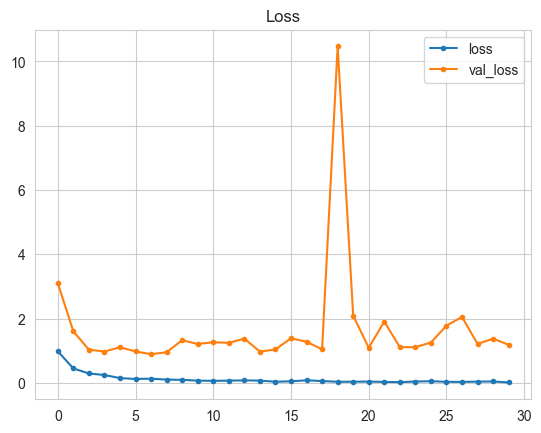

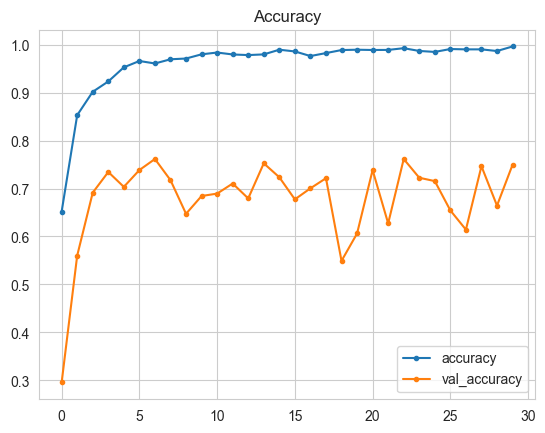

In [20]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

### Load Model

In [21]:
from keras.models import load_model
model = load_model(f"{file_path}/lesion_classifier_model.h5")

### Evaluate Model

In [22]:
evaluation = model.evaluate(df_test)

2023-06-22 04:19:20.515079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2010]
	 [[{{node Placeholder/_4}}]]
2023-06-22 04:19:20.515634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2010]
	 [[{{node Placeholder/_4}}]]


63/63 [==============================] - 13s 181ms/step - loss: 1.1707 - accuracy: 0.7532


### Save evaluation pickle

In [23]:
joblib.dump(value=evaluation,
            filename=f"{file_path}/evaluation.pkl")

['outputs/modelling_evaluation_v6/evaluation.pkl']

## Predict on new data

1/1 [==============================] - 0s 47ms/step


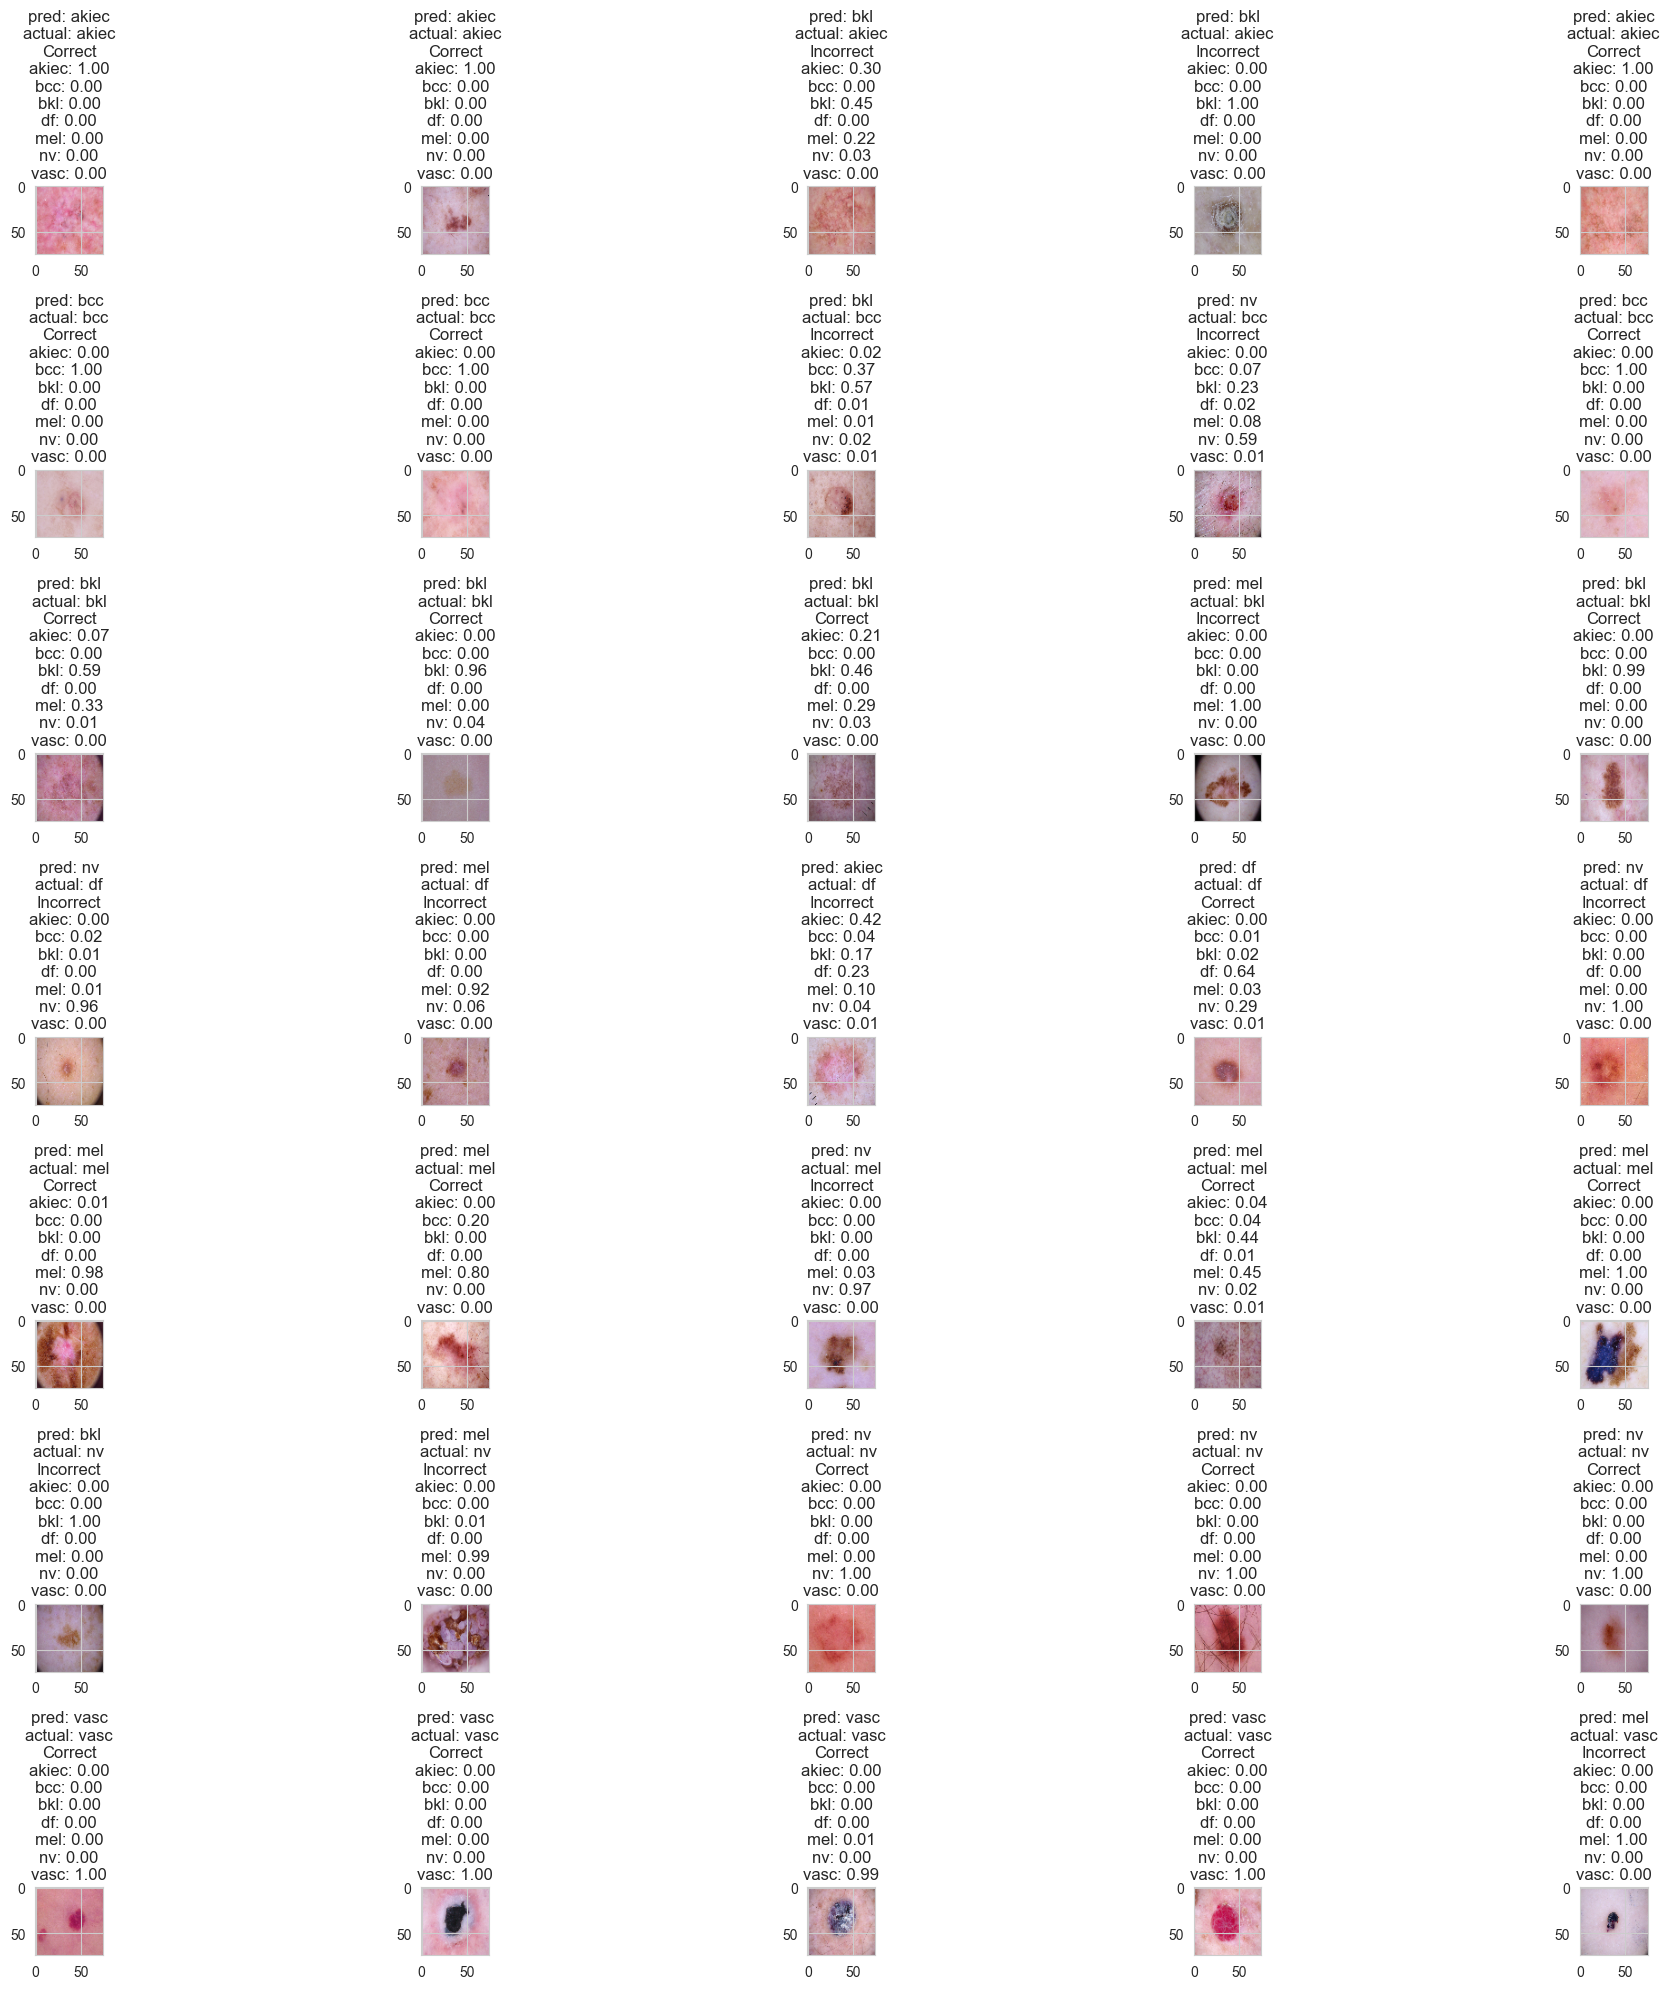

In [24]:
import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

# Create mapping dictionary
target_map = {v: k for v, k in enumerate(class_names)}

f, ax = plt.subplots(7, 5)  # 7 rows for 7 classes, 5 columns for 5 images each
f.set_size_inches(20, 20)  # adjust size for better display

# counters for each class
correct_counts = {label: 0 for label in class_names}
total_counts = {label: 0 for label in class_names}

# assuming train_labels contains the names of the 7 classes
for row, label in enumerate(class_names):
    image_files = os.listdir(test_path + '/' + label)

    # Select 5 random indices
    random_indices = random.sample(range(len(image_files)), 5)

    for col, idx in enumerate(random_indices):
        pil_image = image.load_img(test_path + '/' + label + '/' + image_files[idx], target_size=image_shape, color_mode='rgb')
        
        my_image = image.img_to_array(pil_image)
        my_image = np.expand_dims(my_image, axis=0)/255
        
        #pred_proba = model.predict(my_image)[0]
        pred_logits = model.predict(my_image)[0]
        # Convert logits to probabilities
        pred_proba = softmax(pred_logits)
        
        pred_class_index = np.argmax(pred_proba)  # find the index with max probability
        pred_class = target_map[pred_class_index]
        
        
        # Text for probabilities
        probabilities_text = '\n'.join([f"{target_map[i]}: {p:.2f}" for i, p in enumerate(pred_proba)])

        # Check if prediction is correct
        is_correct = pred_class == label
        if is_correct:
            correct_counts[label] += 1
        total_counts[label] += 1
        
        # Check if prediction is correct
        is_correct = 'Correct' if pred_class == label else 'Incorrect'
        
        # Here I include the predicted class (pred_class), the actual class (label), and the probabilities
        ax[row, col].imshow(pil_image)
        ax[row, col].set_title(f"pred: {pred_class}\nactual: {label}\n{is_correct}\n{probabilities_text}")
        

plt.tight_layout()
plt.show()

## Predict on new data summary

In [25]:
# Calculate and print accuracy for each class
total_correct = 0
for label in train_labels:
    total_correct = total_correct + correct_counts[label] 
    accuracy = (correct_counts[label] / total_counts[label]) * 100 if total_counts[label] > 0 else 0
    print(f"Accuracy for class {label}: {accuracy:.2f}% ({correct_counts[label]}/{total_counts[label]})")
    
total_accuracy = (total_correct / 35) * 100 if total_correct > 0 else 0
print()
print(f"Total correct: {total_correct}")
print(f"Accuracy total: {total_accuracy:.2f}% ({total_correct}/35)")

Accuracy for class akiec: 60.00% (3/5)
Accuracy for class df: 20.00% (1/5)
Accuracy for class bkl: 80.00% (4/5)
Accuracy for class vasc: 80.00% (4/5)
Accuracy for class nv: 60.00% (3/5)
Accuracy for class bcc: 60.00% (3/5)
Accuracy for class mel: 80.00% (4/5)

Total correct: 22
Accuracy total: 62.86% (22/35)


## Predict on new data single

Image shape: (75, 75), Image mode: RGB
df


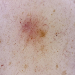

In [26]:
import random
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

from tensorflow.keras.preprocessing import image

pointer = 2
label = train_labels[1]  # select

pil_image = image.load_img(test_path + '/' + label + '/'  + os.listdir(test_path+'/' + label)[pointer], target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
print(f'{label}')
pil_image

In [27]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 75, 75, 3)


In [28]:
# Preprocess the image
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255

# Predict probabilities
pred_logits = model.predict(my_image)[0]
pred_proba = softmax(pred_logits)

# Extract predicted class index
pred_class_index = np.argmax(pred_proba)
pred_proba_max = np.max(pred_proba)  # Maximum probability

# Create mapping dictionary
target_map = {v: k for v, k in enumerate(class_names)}

# Extract predicted class name
pred_class = target_map[pred_class_index]

# Display the result
print(f"Predicted Class: {pred_class}")
print(f"Probability: {pred_proba_max:.2f}")

# Display probability of each class
for i, prob in enumerate(pred_proba):
    print(f"Probability of {target_map[i]}: {prob:.2f}")

1/1 [==============================] - 0s 54ms/step
Predicted Class: nv
Probability: 0.50
Probability of akiec: 0.00
Probability of bcc: 0.01
Probability of bkl: 0.48
Probability of df: 0.00
Probability of mel: 0.00
Probability of nv: 0.50
Probability of vasc: 0.00


## Classification report 

In [29]:
import numpy as np

all_features = []
all_labels = []

# Iterate through the dataset
for features, labels in df_test:
    # Convert tensors to numpy arrays and accumulate
    all_features.append(features.numpy())
    all_labels.append(labels.numpy())

# Optionally, concatenate the list of arrays into a single numpy array
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print("Features shape:", all_features.shape)
print("Labels shape:", all_labels.shape)

Features shape: (2010, 75, 75, 3)
Labels shape: (2010,)


63/63 [==============================] - 10s 158ms/step


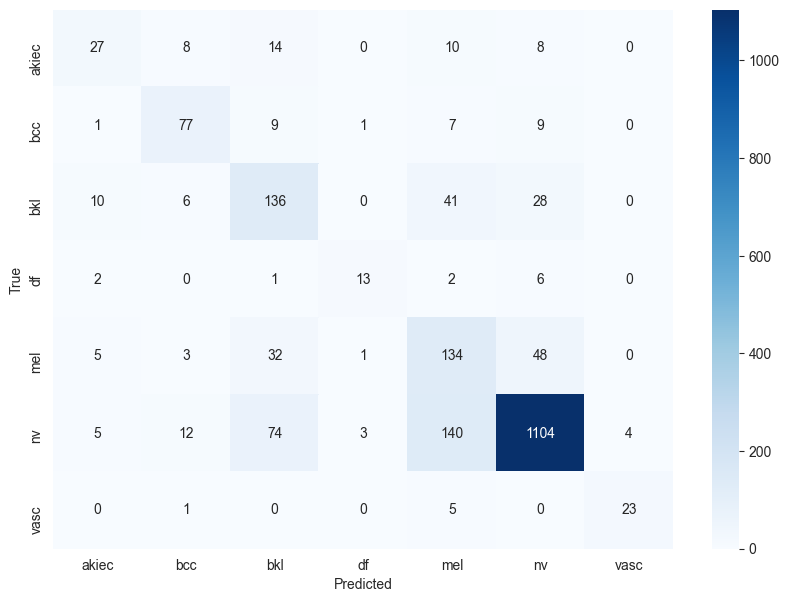

              precision    recall  f1-score   support

       akiec       0.54      0.40      0.46        67
         bcc       0.72      0.74      0.73       104
         bkl       0.51      0.62      0.56       221
          df       0.72      0.54      0.62        24
         mel       0.40      0.60      0.48       223
          nv       0.92      0.82      0.87      1342
        vasc       0.85      0.79      0.82        29

    accuracy                           0.75      2010
   macro avg       0.67      0.65      0.65      2010
weighted avg       0.79      0.75      0.77      2010



In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

X_train = all_features
y_true = all_labels

y_pred = model.predict(X_train)

y_pred_labels = np.argmax(y_pred, axis=1)

unique_labels = np.unique(np.concatenate((y_true, y_pred_labels)))

unique_class_names = [class_names[label] for label in unique_labels]

cm = confusion_matrix(y_true, y_pred_labels, labels=unique_labels)

# Save the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_class_names, yticklabels=unique_class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f'{file_path}/confusion_matrix.png')
plt.show()

# Compute F1 score, Precision, and Recall
class_report = classification_report(y_true, y_pred_labels, target_names=unique_class_names)

# Save the classification report
with open(os.path.join(f'{file_path}/classification_report.txt'), 'w') as file:
    file.write(class_report)

# Display the classification report
print(class_report)

## AUC-ROC and precision-recall curve

2023-06-22 04:19:59.379590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [998]
	 [[{{node Placeholder/_4}}]]
2023-06-22 04:19:59.380007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [998]
	 [[{{node Placeholder/_4}}]]


32/32 [==============================] - 6s 156ms/step


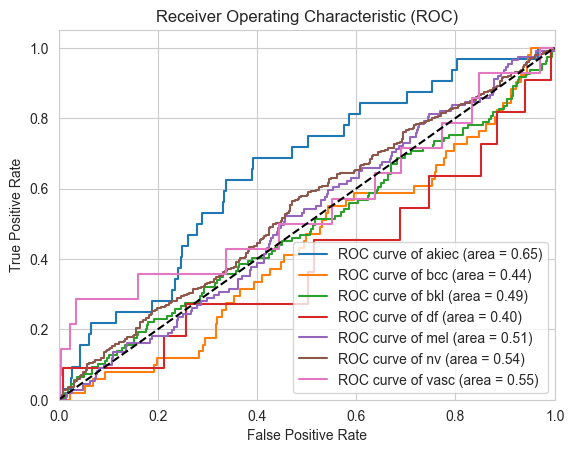

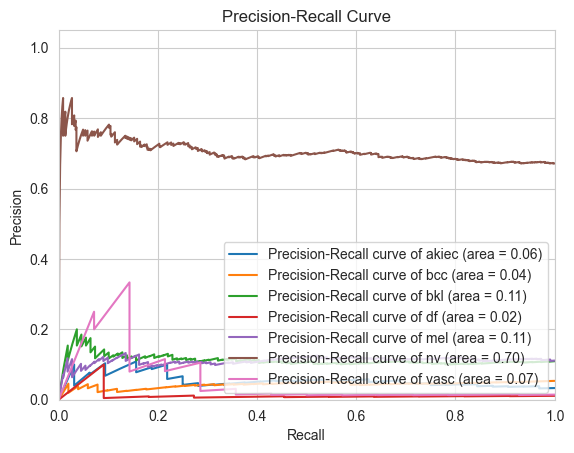

In [31]:
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import os

model = load_model(f'{file_path}/lesion_classifier_model.h5')

# Make predictions using the test dataset
predictions = model.predict(df_val.map(lambda x, y: x))

# Get the true labels
y_true = np.concatenate([y for _, y in df_val], axis=0)

# Binarize the labels
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of {class_name} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig(f'{file_path}/roc_curves.png')
plt.show()

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(y_true_binarized[:, i], predictions[:, i])

# Plot Precision-Recall curves
plt.figure()
for i, class_name in enumerate(class_names):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall curve of {class_name} (area = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.savefig(f'{file_path}/precision_recall_curves.png')
plt.show()

---

---

NOTE

The overall accuracy of the model on the test set is 81%. This means that the model correctly predicted the skin condition 81% of the time.

When looking at individual classes, the model performed the best in identifying Melanocytic Nevi (nv) with a precision of 0.90 and recall of 0.92. Precision is the proportion of true positive identifications (i.e., the model correctly identified the condition) among all positive identifications, and recall is the proportion of true positive identifications among all actual positives.

The model also performed reasonably well in identifying Vascular Lesions (vasc) with a precision of 0.73 and a recall of 0.83. For Dermatofibroma (df), the precision is 0.57 and recall is 0.71.

However, the model had a relatively lower performance in identifying Actinic Keratosis (akiec) and Melanoma (mel). For akiec, the precision is 0.67 and the recall is 0.36, while for mel, the precision is 0.65 and the recall is 0.43.

In general, the model showed good potential in diagnosing skin conditions but further improvements, especially for Actinic Keratosis and Melanoma classes, could enhance its diagnostic capability.

---